<a href="https://colab.research.google.com/github/RodrigoGuedesDP/Computer_Vision/blob/main/cv_labo2_imageclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Computer Vision - Segmentación de imágenes y detección de bordes**

---



*   Este notebook se enfoca en aplicar técnicas fundamentales de visión por computadora para el procesamiento de imágenes. Incluye tres tareas principales: segmentación basada en color de frutas, detección de bordes en imágenes médicas de rayos X, y segmentación de señales de tráfico combinando umbrales de color y métodos de detección de bordes. El objetivo es practicar transformaciones RGB/HSV, filtrado y operadores clásicos como Sobel y Canny.

**Autores:**  

Nieto Espinoza, Brajan E.  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Guedes del Pozo,  Rodrigo J.  
[rodrigo.guedes.d@utec.edu.pe](mailto:rodrigo.guedes.d@utec.edu.pe)

<img src="https://pregrado.utec.edu.pe/sites/default/files/logo-utec-h_0_0.svg" width="190" alt="Logo UTEC" loading="lazy" typeof="foaf:Image">      

---

### 0. Librerías y semillas

In [ ]:
# === Libraries ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from urllib.request import urlopen

from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split, ParameterGrid, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.base import clone

# Reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

### Carga y filtrado del dataset CIFAR-10  
Se carga el conjunto de datos **CIFAR-10**, se seleccionan tres clases específicas (*airplane, automobile, ship*), y se filtran las imágenes correspondientes. Luego, se realiza una división estratificada del 80/20 entre entrenamiento y prueba para mantener la proporción de clases.


In [ ]:
# Cargar CIFAR-10
(X_train_full, y_train_full), (X_test_full, y_test_full) = cifar10.load_data()

# Elegimos 3 clases
# 0='airplane',1='automobile',2='bird',3='cat',4='deer',
SELECTED_CLASSES = [0, 1, 8]

CLASS_NAMES = {
    0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer',
    5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'
}


X_full = X_train_full
y_full = y_train_full.flatten()

# Filtrar a las 3 clases elegidas
mask = np.isin(y_full, SELECTED_CLASSES)
X = X_full[mask]
y = y_full[mask]

N_PER_CLASS = None
if N_PER_CLASS is not None:
    X_sel, y_sel = [], []
    for c in SELECTED_CLASSES:
        idx_c = np.where(y == c)[0]
        np.random.shuffle(idx_c)
        idx_c = idx_c[:N_PER_CLASS]
        X_sel.append(X[idx_c])
        y_sel.append(y[idx_c])
    X = np.concatenate(X_sel, axis=0)
    y = np.concatenate(y_sel, axis=0)

# Separación 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Info
def dist_clases(vec):
    uniques, counts = np.unique(vec, return_counts=True)
    return {CLASS_NAMES[int(k)]: int(v) for k, v in zip(uniques, counts)}

print("Clases seleccionadas:", [f"{c}={CLASS_NAMES[c]}" for c in SELECTED_CLASSES])
print("Dimensiones X_train:", X_train.shape, "X_test:", X_test.shape)
print("Distribución train:", dist_clases(y_train))
print("Distribución test :", dist_clases(y_test))


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Clases seleccionadas: ['0=airplane', '1=automobile', '8=ship']
Dimensiones X_train: (12000, 32, 32, 3) X_test: (3000, 32, 32, 3)
Distribución train: {'airplane': 4000, 'automobile': 4000, 'ship': 4000}
Distribución test : {'airplane': 1000, 'automobile': 1000, 'ship': 1000}


### Extracción y visualización de características  
Se definen funciones para extraer **8 características** de cada imagen (canales RGB, HSV y bordes Sobel horizontal/vertical), generando vectores 1D. Luego, se visualizan los canales de una imagen aleatoria y se construyen los conjuntos de características para entrenamiento y prueba.


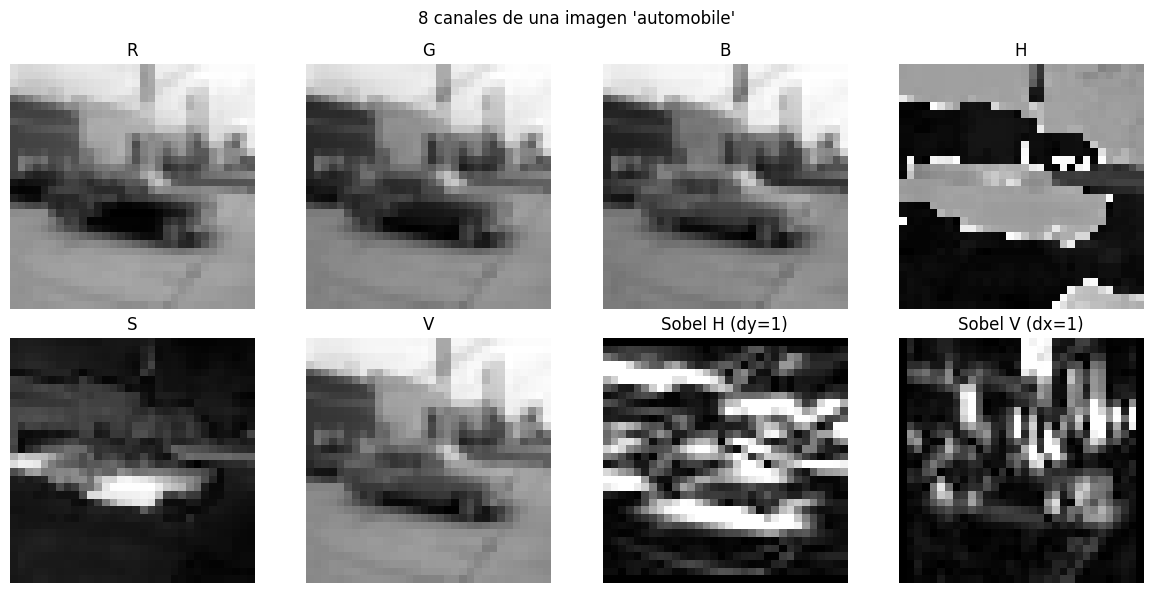

Extrayendo características (esto puede tardar un poco)...
X_train_feat: (12000, 8192) X_test_feat: (3000, 8192)


In [ ]:
def extract_8_features(img_rgb):
    """
    img_rgb: (32,32,3) uint8 en espacio RGB.
    Retorna un vector 1D con la concatenación de:
    [R, G, B, H, S, V, Sobel_H (dy=1), Sobel_V (dx=1)]  (todos aplanados).
    """
    # Canales RGB
    R = img_rgb[:, :, 0].astype(np.float32)
    G = img_rgb[:, :, 1].astype(np.float32)
    B = img_rgb[:, :, 2].astype(np.float32)

    # HSV
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    H = hsv[:, :, 0].astype(np.float32)
    S = hsv[:, :, 1].astype(np.float32)
    V = hsv[:, :, 2].astype(np.float32)

    # Bordes Sobel en escala de grises
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY).astype(np.float32)
    sobel_h = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3)  # horizontales
    sobel_v = cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3)  # verticales
    sobel_h = cv2.convertScaleAbs(sobel_h).astype(np.float32)
    sobel_v = cv2.convertScaleAbs(sobel_v).astype(np.float32)

    # Concatenar y aplanar
    feats = np.stack([R, G, B, H, S, V, sobel_h, sobel_v], axis=0)  # (8, 32, 32)
    return feats.reshape(-1)  # (8*32*32,)

def batch_extract_features(X):
    return np.vstack([extract_8_features(img) for img in X])

# Visualización de los 8 canales para 1 imagen aleatoria del set de entrenamiento
SHOW_INDEX = np.random.randint(0, len(X_train))
img = X_train[SHOW_INDEX]

R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
Hc, Sc, Vc = hsv[:, :, 0], hsv[:, :, 1], hsv[:, :, 2]
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
sobel_h = cv2.convertScaleAbs(cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=3))
sobel_v = cv2.convertScaleAbs(cv2.Sobel(gray, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=3))

titles = ["R", "G", "B", "H", "S", "V", "Sobel H (dy=1)", "Sobel V (dx=1)"]
planes = [R, G, B, Hc, Sc, Vc, sobel_h, sobel_v]

plt.figure(figsize=(12, 6))
for i, (t, p) in enumerate(zip(titles, planes)):
    ax = plt.subplot(2, 4, i+1)
    ax.imshow(p, cmap='gray')
    ax.set_title(t)
    ax.axis('off')
plt.suptitle(f"8 canales de una imagen '{CLASS_NAMES[int(y_train[SHOW_INDEX])]}'")
plt.tight_layout()
plt.show()

# Construir features para train y test
print("Extrayendo características (esto puede tardar un poco)...")
X_train_feat = batch_extract_features(X_train)
X_test_feat  = batch_extract_features(X_test)
print("X_train_feat:", X_train_feat.shape, "X_test_feat:", X_test_feat.shape)


### Entrenamiento y evaluación con Regresión Logística  
Se define un pipeline con **Regresión Logística** y se realiza una búsqueda exhaustiva de hiperparámetros mediante con *cross-validation*. Luego, se identifican los mejores modelos según **accuracy** y **f1_macro**, se reentrenan y evalúan en el conjunto de prueba, mostrando los reportes de clasificación, matrices de confusión y ejemplos visuales de predicciones.


[LR] Combinaciones totales: 16

[LR] 1/16 -> acc=0.7535 | f1_macro=0.7530 | params={'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
[LR] 2/16 -> acc=0.7578 | f1_macro=0.7576 | params={'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
[LR] 3/16 -> acc=0.7535 | f1_macro=0.7530 | params={'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
[LR] 4/16 -> acc=0.7562 | f1_macro=0.7561 | params={'logreg__C': 0.01, 'logreg__class_weight': 'balanced', 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
[LR] 5/16 -> acc=0.7250 | f1_macro=0.7250 | params={'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
[LR] 6/16 -> acc=0.7290 | f1_macro=0.7292 | params={'logreg__C': 0.1, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
[LR] 7/16 -> acc=0.7250 | f1

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LOGISTIC REGRESSION — Mejor por ACCURACY (en TEST) ===
              precision    recall  f1-score   support

    airplane       0.73      0.71      0.72      1000
  automobile       0.82      0.82      0.82      1000
        ship       0.71      0.73      0.72      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.76      0.75      3000



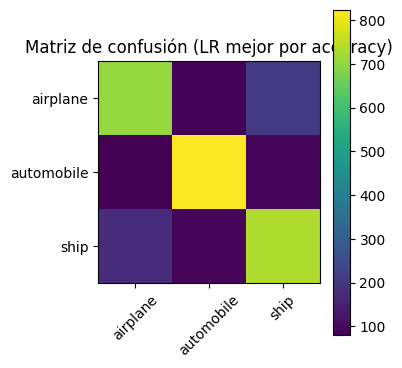

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LOGISTIC REGRESSION — Mejor por F1_MACRO (en TEST) ===
              precision    recall  f1-score   support

    airplane       0.73      0.71      0.72      1000
  automobile       0.82      0.82      0.82      1000
        ship       0.71      0.73      0.72      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.75      0.75      3000
weighted avg       0.76      0.76      0.75      3000



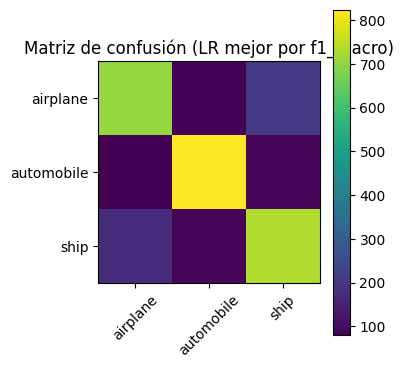

>>> Para (3.2) usamos el modelo LR con MEJOR ACCURACY en TEST.
>>> Mejor por accuracy (CV): 0.7578 | params={'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}
>>> Mejor por f1_macro (CV): 0.7576 | params={'logreg__C': 0.01, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


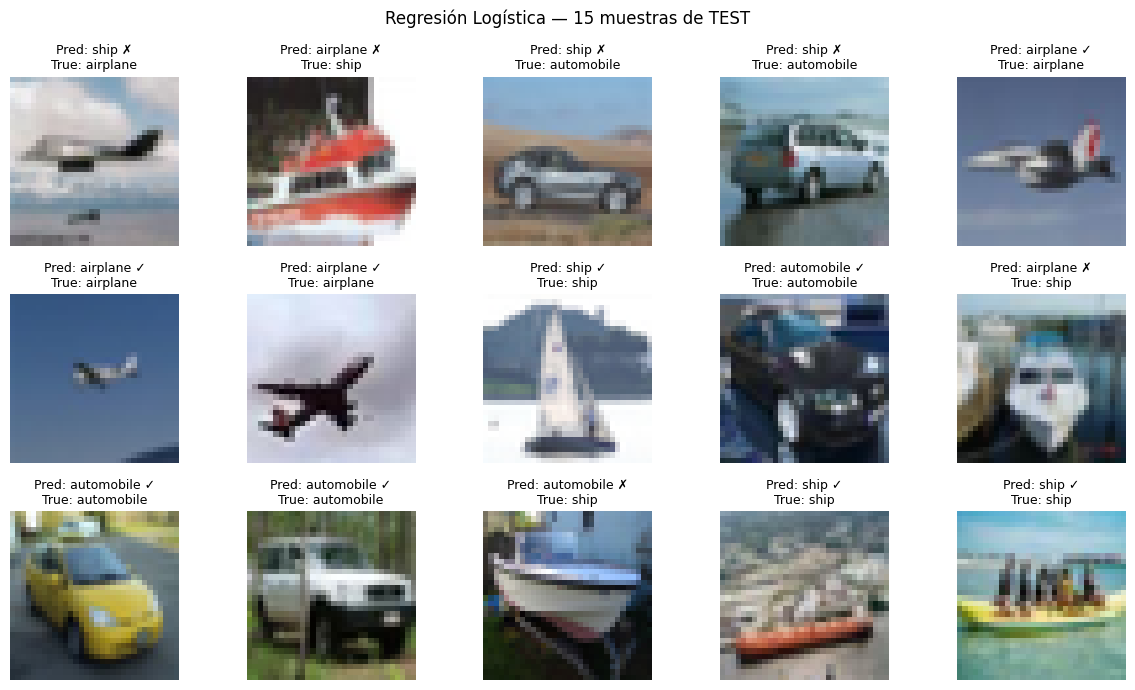

In [ ]:
METRICA_DECISION = 'accuracy'  # 'accuracy' o 'f1_macro'

# Pipeline base
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=2000, multi_class='ovr'))
])

# Espacio de búsqueda
param_grid_lr = {
    'logreg__C': [0.01, 0.1, 10, 100],
    'logreg__solver': ['liblinear', 'lbfgs'],
    'logreg__penalty': ['l2'],
    'logreg__class_weight': [None, 'balanced'],
}

scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = list(ParameterGrid(param_grid_lr))
total = len(grid)
print(f"[LR] Combinaciones totales: {total}\n")

all_results_lr = []

for i, params in enumerate(grid, start=1):
    est = clone(pipe_lr).set_params(**params)
    cv_res = cross_validate(
        est, X_train_feat, y_train,
        scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False
    )
    mean_acc = float(np.mean(cv_res['test_accuracy']))
    mean_f1  = float(np.mean(cv_res['test_f1_macro']))
    all_results_lr.append({'params': params, 'mean_accuracy': mean_acc, 'mean_f1_macro': mean_f1})
    print(f"[LR] {i}/{total} -> acc={mean_acc:.4f} | f1_macro={mean_f1:.4f} | params={params}")

# ---- Resumen final TOP-5 por métrica (CV) ----
def top_k(results, key, k=5):
    return sorted(results, key=lambda d: d[key], reverse=True)[:k]

print("\n=== [LR] TOP-5 (CV) por accuracy ===")
for r in top_k(all_results_lr, 'mean_accuracy'):
    print({'mean_accuracy': round(r['mean_accuracy'], 4), 'params': r['params']})

print("\n=== [LR] TOP-5 (CV) por f1_macro ===")
for r in top_k(all_results_lr, 'mean_f1_macro'):
    print({'mean_f1_macro': round(r['mean_f1_macro'], 4), 'params': r['params']})

# ---- Reentrenar mejores y evaluar en TEST ----
best_acc = max(all_results_lr, key=lambda d: d['mean_accuracy'])
best_f1  = max(all_results_lr, key=lambda d: d['mean_f1_macro'])

best_acc_est = clone(pipe_lr).set_params(**best_acc['params']).fit(X_train_feat, y_train)
y_pred_acc = best_acc_est.predict(X_test_feat)

print("\n=== LOGISTIC REGRESSION — Mejor por ACCURACY (en TEST) ===")
print(classification_report(y_test, y_pred_acc, target_names=[CLASS_NAMES[c] for c in SELECTED_CLASSES]))

cm_acc = confusion_matrix(y_test, y_pred_acc, labels=SELECTED_CLASSES)
plt.figure(figsize=(4,4))
plt.imshow(cm_acc, interpolation='nearest')
plt.title('Matriz de confusión (LR mejor por accuracy)')
plt.xticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES], rotation=45)
plt.yticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES])
plt.colorbar()
plt.tight_layout()
plt.show()

best_f1_est = clone(pipe_lr).set_params(**best_f1['params']).fit(X_train_feat, y_train)
y_pred_f1 = best_f1_est.predict(X_test_feat)

print("\n=== LOGISTIC REGRESSION — Mejor por F1_MACRO (en TEST) ===")
print(classification_report(y_test, y_pred_f1, target_names=[CLASS_NAMES[c] for c in SELECTED_CLASSES]))

cm_f1 = confusion_matrix(y_test, y_pred_f1, labels=SELECTED_CLASSES)
plt.figure(figsize=(4,4))
plt.imshow(cm_f1, interpolation='nearest')
plt.title('Matriz de confusión (LR mejor por f1_macro)')
plt.xticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES], rotation=45)
plt.yticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES])
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- Elegir modelo final para 3.2 ----
if METRICA_DECISION == 'f1_macro':
    best_lr = best_f1_est
    y_pred_best = y_pred_f1
    tag_best = "F1_MACRO"
else:
    best_lr = best_acc_est
    y_pred_best = y_pred_acc
    tag_best = "ACCURACY"

print(f">>> Para (3.2) usamos el modelo LR con MEJOR {tag_best} en TEST.")
print(f">>> Mejor por accuracy (CV): {best_acc['mean_accuracy']:.4f} | params={best_acc['params']}")
print(f">>> Mejor por f1_macro (CV): {best_f1['mean_f1_macro']:.4f} | params={best_f1['params']}")

# ---- 3.2: Visualización de 15 imágenes del TEST ----
n_vis = 15
idxs = np.random.choice(len(X_test), size=n_vis, replace=False)

plt.figure(figsize=(12, 7))
for i, idx in enumerate(idxs, 1):
    img = X_test[idx]
    true_c = int(y_test[idx])
    pred_c = int(y_pred_best[idx])
    correcto = (true_c == pred_c)
    titulo = f"Pred: {CLASS_NAMES[pred_c]} {'✓' if correcto else '✗'}\nTrue: {CLASS_NAMES[true_c]}"
    ax = plt.subplot(3, 5, i)
    ax.imshow(img)
    ax.set_title(titulo, fontsize=9)
    ax.axis('off')
plt.suptitle("Regresión Logística — 15 muestras de TEST")
plt.tight_layout()
plt.show()


### Entrenamiento y evaluación con K-Nearest Neighbors (KNN)  
Se construye un pipeline con **KNN** y se realiza una búsqueda de hiperparámetros mediante *cross-validation* para optimizar **accuracy** y **f1_macro**. Los mejores modelos se reentrenan y evalúan en el conjunto de prueba, mostrando los reportes de clasificación, matrices de confusión y una visualización de predicciones sobre 15 imágenes de test.


[KNN] Combinaciones totales: 24

[KNN] 1/24 -> acc=0.6263 | f1_macro=0.6137 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'uniform'}
[KNN] 2/24 -> acc=0.6397 | f1_macro=0.6315 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
[KNN] 3/24 -> acc=0.5907 | f1_macro=0.5673 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'uniform'}
[KNN] 4/24 -> acc=0.6062 | f1_macro=0.5903 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
[KNN] 5/24 -> acc=0.6349 | f1_macro=0.6224 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'uniform'}
[KNN] 6/24 -> acc=0.6408 | f1_macro=0.6297 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
[KNN] 7/24 -> acc=0.6065 | f1_macro=0.5857 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'uniform'

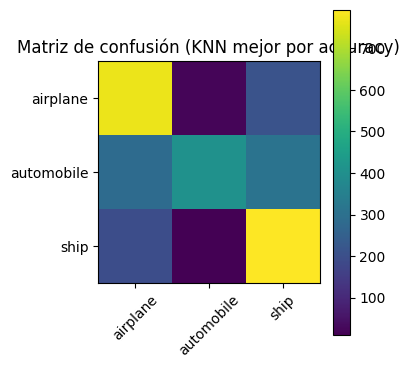


=== KNN — Mejor por F1_MACRO (en TEST) ===
              precision    recall  f1-score   support

    airplane       0.62      0.77      0.69      1000
  automobile       0.91      0.41      0.57      1000
        ship       0.60      0.79      0.68      1000

    accuracy                           0.65      3000
   macro avg       0.71      0.65      0.64      3000
weighted avg       0.71      0.65      0.64      3000



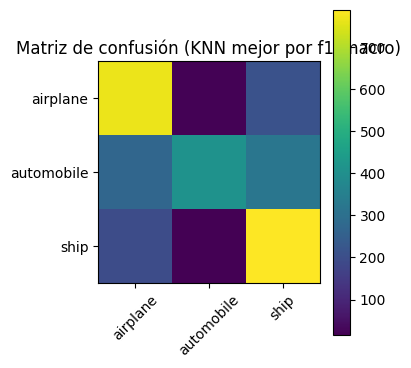

>>> Para (4.2) usamos el modelo KNN con MEJOR ACCURACY en TEST.
>>> Mejor por accuracy (CV): 0.6408 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
>>> Mejor por f1_macro (CV): 0.6315 | params={'knn__leaf_size': 15, 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}


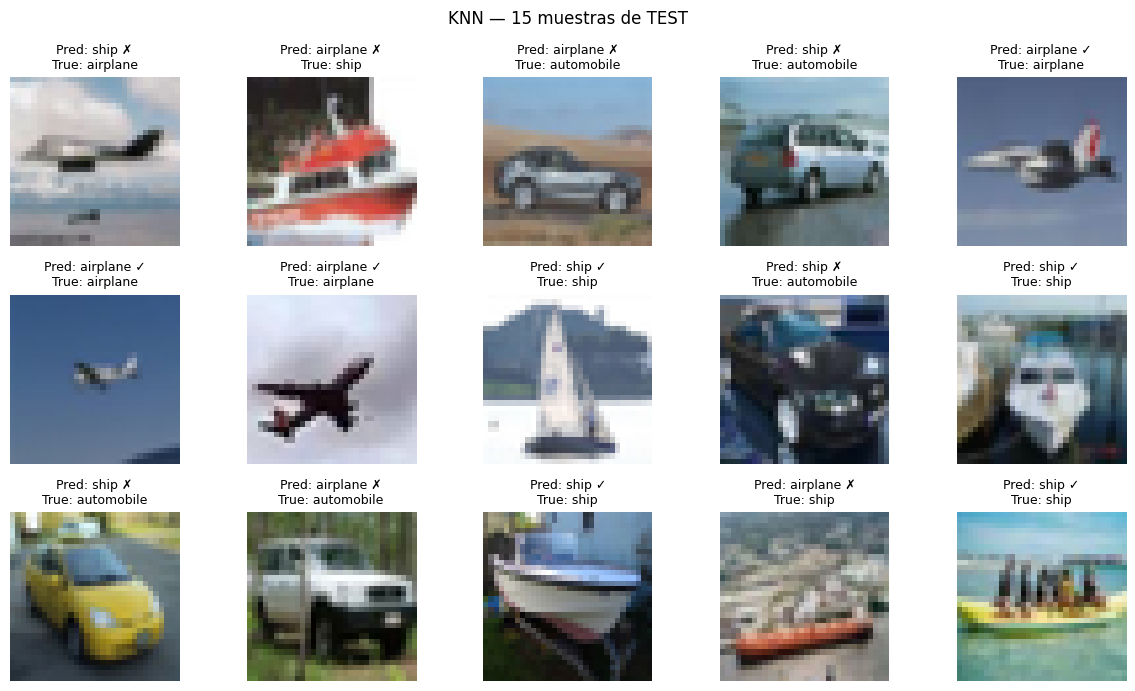

In [ ]:
METRICA_DECISION_KNN = 'accuracy'  # 'accuracy' o 'f1_macro'

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Espacio de búsqueda (60 combinaciones)
param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1, 2],            # Manhattan (1) o Euclídea (2)
    'knn__leaf_size': [15, 45],
}

scoring = {'accuracy': 'accuracy', 'f1_macro': 'f1_macro'}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid = list(ParameterGrid(param_grid_knn))
total = len(grid)
print(f"[KNN] Combinaciones totales: {total}\n")

all_results_knn = []

for i, params in enumerate(grid, start=1):
    est = clone(pipe_knn).set_params(**params)
    cv_res = cross_validate(
        est, X_train_feat, y_train,
        scoring=scoring, cv=cv, n_jobs=-1, return_train_score=False
    )
    mean_acc = float(np.mean(cv_res['test_accuracy']))
    mean_f1  = float(np.mean(cv_res['test_f1_macro']))
    all_results_knn.append({'params': params, 'mean_accuracy': mean_acc, 'mean_f1_macro': mean_f1})
    print(f"[KNN] {i}/{total} -> acc={mean_acc:.4f} | f1_macro={mean_f1:.4f} | params={params}")

# ---- Resumen final TOP-5 por métrica (CV) ----
def top_k(results, key, k=5):
    return sorted(results, key=lambda d: d[key], reverse=True)[:k]

print("\n=== [KNN] TOP-5 (CV) por accuracy ===")
for r in top_k(all_results_knn, 'mean_accuracy'):
    print({'mean_accuracy': round(r['mean_accuracy'], 4), 'params': r['params']})

print("\n=== [KNN] TOP-5 (CV) por f1_macro ===")
for r in top_k(all_results_knn, 'mean_f1_macro'):
    print({'mean_f1_macro': round(r['mean_f1_macro'], 4), 'params': r['params']})

# ---- Reentrenar mejores y evaluar en TEST ----
best_acc_knn = max(all_results_knn, key=lambda d: d['mean_accuracy'])
best_f1_knn  = max(all_results_knn, key=lambda d: d['mean_f1_macro'])

best_acc_est_knn = clone(pipe_knn).set_params(**best_acc_knn['params']).fit(X_train_feat, y_train)
y_pred_acc_knn = best_acc_est_knn.predict(X_test_feat)

print("\n=== KNN — Mejor por ACCURACY (en TEST) ===")
print(classification_report(y_test, y_pred_acc_knn, target_names=[CLASS_NAMES[c] for c in SELECTED_CLASSES]))

cm_acc_knn = confusion_matrix(y_test, y_pred_acc_knn, labels=SELECTED_CLASSES)
plt.figure(figsize=(4,4))
plt.imshow(cm_acc_knn, interpolation='nearest')
plt.title('Matriz de confusión (KNN mejor por accuracy)')
plt.xticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES], rotation=45)
plt.yticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES])
plt.colorbar()
plt.tight_layout()
plt.show()

best_f1_est_knn = clone(pipe_knn).set_params(**best_f1_knn['params']).fit(X_train_feat, y_train)
y_pred_f1_knn = best_f1_est_knn.predict(X_test_feat)

print("\n=== KNN — Mejor por F1_MACRO (en TEST) ===")
print(classification_report(y_test, y_pred_f1_knn, target_names=[CLASS_NAMES[c] for c in SELECTED_CLASSES]))

cm_f1_knn = confusion_matrix(y_test, y_pred_f1_knn, labels=SELECTED_CLASSES)
plt.figure(figsize=(4,4))
plt.imshow(cm_f1_knn, interpolation='nearest')
plt.title('Matriz de confusión (KNN mejor por f1_macro)')
plt.xticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES], rotation=45)
plt.yticks(range(len(SELECTED_CLASSES)), [CLASS_NAMES[c] for c in SELECTED_CLASSES])
plt.colorbar()
plt.tight_layout()
plt.show()

# ---- Elegir modelo final para 4.2 ----
if METRICA_DECISION_KNN == 'f1_macro':
    best_knn = best_f1_est_knn
    y_pred_best_knn = y_pred_f1_knn
    tag_best_knn = "F1_MACRO"
else:
    best_knn = best_acc_est_knn
    y_pred_best_knn = y_pred_acc_knn
    tag_best_knn = "ACCURACY"

print(f">>> Para (4.2) usamos el modelo KNN con MEJOR {tag_best_knn} en TEST.")
print(f">>> Mejor por accuracy (CV): {best_acc_knn['mean_accuracy']:.4f} | params={best_acc_knn['params']}")
print(f">>> Mejor por f1_macro (CV): {best_f1_knn['mean_f1_macro']:.4f} | params={best_f1_knn['params']}")

# ---- 4.2: Visualización de 15 imágenes del TEST ----
n_vis = 15
idxs = np.random.choice(len(X_test), size=n_vis, replace=False)

plt.figure(figsize=(12, 7))
for i, idx in enumerate(idxs, 1):
    img = X_test[idx]
    true_c = int(y_test[idx])
    pred_c = int(y_pred_best_knn[idx])
    correcto = (true_c == pred_c)
    titulo = f"Pred: {CLASS_NAMES[pred_c]} {'✓' if correcto else '✗'}\nTrue: {CLASS_NAMES[true_c]}"
    ax = plt.subplot(3, 5, i)
    ax.imshow(img)
    ax.set_title(titulo, fontsize=9)
    ax.axis('off')
plt.suptitle("KNN — 15 muestras de TEST")
plt.tight_layout()
plt.show()
